In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import sys
from pathlib import Path
import xarray as xr
import cfgrib
import cartopy.crs as ccrs  # Projeções de mapas.
import cartopy.feature as cfeature  # Elementos geográficos.
from matplotlib.tri import Triangulation

#Import local libraries
import aux

In [2]:
year='2018'
month='12'
month_abbr = datetime.datetime.strptime(month, "%m").strftime("%b")

base_dir='/pesq/dados/monan/users/madeleine.gacita/global_data/'

In [62]:
water_var_dict={
    "PW": {
        "era5_name" : "tcwv",
        "era5_longname" :"total_column_water_vapour",
        "ceres_name" : "adj_pw", 
        "monan_name" : "precipw",
        "unit" : "kg*m^{-2}",
        "label" : "Precipitable water",
        "vmin" : 0,
        "vmax" : 60,
        "vmin_diff" : -20,
        "vmax_diff" : 20,
    },
    "PC": {
        "era5_name" : "tclw",
        "era5_longname" :"total_column_cloud_liquid_water",
        "ceres_name" : "obs_cld_lwp", 
        "monan_name" : "",
        "unit" : "kg*m^{-2}",
        "label" : "Total column cloud liquid water",
        "vmin" : 0,
        "vmax" : 5,
        "vmin_diff" : -20,
        "vmax_diff" : 20,
    },
    "PI": {
        "era5_name": "tciw",
        "era5_longname" :"total_column_cloud_ice_water",
        "ceres_name" : "obs_cld_iwp", 
        "monan_name" : "",
        "unit" : "kg*m^{-2}",
        "label" : "Total column cloud ice water",
        "vmin" : 0,
        "vmax" : 5,
        "vmin_diff" : -20,
        "vmax_diff" : 20,
    },
    "PCI": {
        "era5_name" : "",
        "era5_longname" : "",
        "ceres_name" : "", 
        "monan_name" : "precipci",
        "unit" : "kg*m^{-2}",
        "label" : "Total column cloud ice water",
        "vmin" : 0,
        "vmax" : 5,
        "vmin_diff" : -20,
        "vmax_diff" : 20,
    },
#     "TISR": {
#         "era5_name" : "tisr",
#         "era5_longname" : "toa_incident_solar_radiation",
#         "ceres_name" : "toa_sw_insol", 
#         "monan_name" : "swdnt",
#         "unit" : "W m^{-2}",
#         "label" : "TOA incident short-wave (solar) radiation",
#         "vmin" : 0,
#         "24vmin" : 0,
#         "vmax" : 1300,
#         "24vmax" : 8000
#     }
}

# surf_flux_dict={
#     "HF": {
#         "era5_name" : "sshf",
#         "era5_longname" : "surface_sensible_heat_flux",
#         "monan_name" : "hfx", 
#         "unit" : "W/m**2",
#         "label" : "Sensible heat flux"
#     },
#     "LF": {
#         "era5_name": "sslf",
#         "era5_longname":"surface_latent_heat_flux",
#         "monan_name": "lf", 
#         "unit": "W m^{-2}",
#         "label": "Latent heat flux"
#     }
# }

# profile_vars_dict={
#     "ISR": {
#         "monan_name" : "ssrd",
#         "ceres_name" : "adj_all_sw_dn",
#         "unit" : "W m^{-2}",
#         "label" : "Incoming shortwave radiation"
#     },
#     "OSR": {
#         "monan_name" : "ssrd",
#         "ceres_name" : "adj_all_sw_up", 
#         "unit" : "W m^{-2}",
#         "label" : "Outgoing shortwave radiation"
#     },
#     "ILR": {
#         "monan_name" : "ttrc",
#         "ceres_name" : "adj_all_lw_dn", 
#         "unit" : "W m^{-2}",
#         "label" : "Incoming longwave radiation"
#     },
#     "OLR": {
#         "monan_name" : "ttr",
#         "ceres_name" : "adj_all_lw_up", 
#         "unit" : "W m^{-2}",
#         "label" : "Outgoing longwave radiation"
#     }    
# }

In [4]:
def apply_lon_lat_conventions(ds):
    # Renames
    if "lon" in ds.dims:
        ds = ds.rename({"lon": "longitude"})
    if "lat" in ds.dims:
        ds = ds.rename({"lat": "latitude"})
 
    # Flip latitudes (ensure they are monotonic increasing)
    if "latitude" in ds.dims:
        lats = ds["latitude"]
        if len(lats) > 1 and lats[0] > lats[-1]:
            ds = ds.reindex(latitude=ds.latitude[::-1])
 
    # Convert longitude to [-180, 180[
    if "longitude" in ds.dims and ds["longitude"].max() > 180:
        lons = ds["longitude"]
        lons_attrs = lons.attrs
        new_lons = np.concatenate([lons[lons >= 180], lons[lons < 180]])
        ds = ds.reindex(longitude=new_lons)
        ds = ds.assign_coords(longitude=(((ds["longitude"] + 180) % 360) - 180))
        ds["longitude"].attrs = lons_attrs
    return ds

# Opening CERES SYN_1deg Ed A

In [5]:
syn_file_arg = base_dir+"CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406."+year+month+".hdf"
path = Path(syn_file_arg)
print(syn_file_arg)

if not path.exists():
    print(f"File does not exist: {path!s}")
else:
    from pyhdf.SD import SD, SDC
    sd = SD(str(path), SDC.READ)
    print("pyhdf.SD opened file — datasets:")
    names = list(sd.datasets().keys())


/pesq/dados/monan/users/madeleine.gacita/global_data/CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406.201812.hdf
pyhdf.SD opened file — datasets:


# water vapour in the column

## Precipitable_water

### Plots general settings

In [6]:
var="PW"
fig_path="/pesq/dados/monan/users/madeleine.gacita/figuras_rodada/"

UTC_hour_plot=15
target_lon = -60.0

### Plotting for {UTC_hour_plot}

## Extracting CERES {var} data from opened file

In [68]:
var_names = [water_var_dict[var]['ceres_name']]
CER_data_dict = {}
for desired in var_names:
    target = None
    for n in var_names:
        if n == desired or desired in n:
            target = n
            break
    if target is None:
        print(f"Dataset '{desired}' not found in the file. Available datasets: {names[:20]}")
    else:
        print(f"Reading dataset: {target}")
        sds = sd.select(target)
        try:
            CER_data = sds.get()              
            print(f"{desired} shape: {CER_data.shape}, dtype: {CER_data.dtype}")
            # Apply scale/offset if present in attributes
            try:
                attrs = sds.attributes()
                scale = attrs.get('scale_factor') or attrs.get('scale') or attrs.get('SCALE')
                offset = attrs.get('add_offset') or attrs.get('offset') or attrs.get('OFFSET')
                if scale is not None:
                    CER_data = CER_data * float(scale)
                if offset is not None:
                    CER_data = CER_data + float(offset)
                if var=="PW":
                    # CERES data of precip water is in cm, converting to kg/m2
                    CER_data = CER_data * 10
                elif var=="PC" or var=="PI":
                    # CERES data of cloud water and ice is in g/m2, converting to kg/m2
                    CER_data = CER_data / s1000
                    
            
            except Exception:
                pass
            CER_data_dict[desired] = CER_data
            try:
                sds.end()
            except Exception:
                pass

            # Find longitude and latitude coordinates for georeferenced plotting
            lon_coords = None
            lat_coords = None
            lon_names = [n for n in names if 'lon' in n.lower() or 'longitude' in n.lower()]
            for lname in lon_names:
                try:
                    lds = sd.select(lname)
                    try:
                        lvals = lds.get()
                    except Exception:
                        lvals = lds[:]
                    lon_coords = np.array(lvals)
                    try:
                        lds.end()
                    except Exception:
                        pass
                    break
                except Exception:
                    continue
            lat_names = [n for n in names if 'lat' in n.lower() or 'latitude' in n.lower()]
            for lname in lat_names:
                try:
                    lds = sd.select(lname)
                    try:
                        lvals = lds.get()
                    except Exception:
                        lvals = lds[:]
                    lat_coords = np.array(lvals)
                    try:
                        lds.end()
                    except Exception:
                        pass
                    break
                except Exception:
                    continue
            gmt_hr_index = sd.select('gmt_hr_index').get()
        
        except Exception:
            CER_data = sds[:]  


Reading dataset: adj_pw
adj_pw shape: (24, 180, 360), dtype: float32


In [74]:
hour_data = sd.select('gmt_hr_index').get()
CERES_var=water_var_dict[var]['ceres_name']
CER_data_xa = xr.DataArray(
    CER_data,  # shape (time, lat, lon)
    dims=("gmt_hr_index", "lat", "lon"),
    coords={
        "gmt_hr_index": hour_data,  # e.g. 0–23 or actual datetime
        "lat": lat_coords,
        "lon": lon_coords
    },
    name=CERES_var
)
print(CER_data_xa)

<xarray.DataArray 'adj_pw' (gmt_hr_index: 24, lat: 180, lon: 360)> Size: 6MB
array([[[1.8356802 , 1.8356802 , 1.8356802 , ..., 1.8356802 ,
         1.8356802 , 1.8356802 ],
        [1.8504121 , 1.8504121 , 1.8504121 , ..., 1.8875244 ,
         1.8875244 , 1.8875244 ],
        [1.8333589 , 1.8333589 , 1.8333589 , ..., 1.8884069 ,
         1.8884069 , 1.8884069 ],
        ...,
        [0.9750727 , 0.9750727 , 0.9750727 , ..., 0.94674   ,
         0.94674   , 0.94674   ],
        [0.9772457 , 0.9772457 , 0.9772457 , ..., 0.97306263,
         0.97306263, 0.97306263],
        [1.1622136 , 1.1622136 , 1.1622136 , ..., 1.1622136 ,
         1.1622136 , 1.1622136 ]],

       [[1.8467112 , 1.8467112 , 1.8467112 , ..., 1.8467112 ,
         1.8467112 , 1.8467112 ],
        [1.8675734 , 1.8675734 , 1.8675734 , ..., 1.9097501 ,
         1.9097501 , 1.9097501 ],
        [1.8521249 , 1.8521249 , 1.8521249 , ..., 1.9112116 ,
         1.9112116 , 1.9112116 ],
...
        [0.9917584 , 0.9917584 , 0.99175

## Plotting CERES {var} data at {UTC_hour_plot}

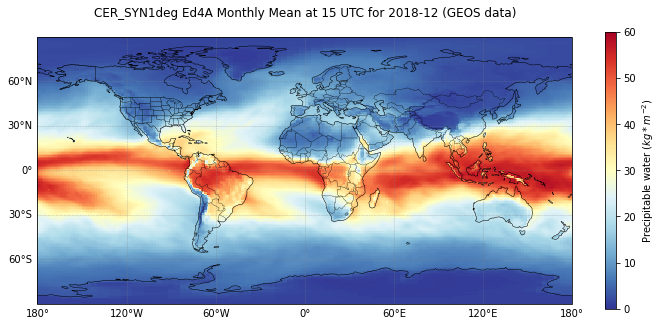

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_PW_2018_12_15.png


In [9]:
# If data is 3D with time as first dim, plot first time slice
print()

# Select values at hour {UTC_hour_plot}
if UTC_hour_plot==0:
    time_mask = hour_data == 24
else:
    time_mask = hour_data == UTC_hour_plot


CER_data_sel_time = CER_data[time_mask][0]

    
# Handle 2D or 1D coordinate arrays
if lon_coords.ndim == 2 and lat_coords.ndim == 2:
    X, Y = lon_coords, lat_coords
else:
    X, Y = np.meshgrid(lon_coords, lat_coords)
    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the data (sorted by latitude to avoid ValueError)
im = plt.pcolormesh(X, Y, CER_data_sel_time,

    cmap='RdYlBu_r',
    vmin=water_var_dict[var]['vmin'],
    vmax=water_var_dict[var]['vmax']
#                     ,
#     cbar_kwargs={
#         'shrink': 0.5,  # Make colorbar 70% of the plot height
#         'aspect': 25,   # Control width (higher = thinner)
#         'pad': 0.05,    # Space between plot and colorbar
#         'label': 'ERA5 Incoming Surface Solar Radiation (W/m²)'
#     }
)
plt.colorbar(im, 
             shrink = 0.5,  # Make colorbar 70% of the plot height
             aspect = 25,   # Control width (higher = thinner)
             pad = 0.05,    # Space between plot and colorbar
             label = f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']})$")

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month} (GEOS data)", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")




#### Plotting CERES {var} monthly mean data 

(180, 360)


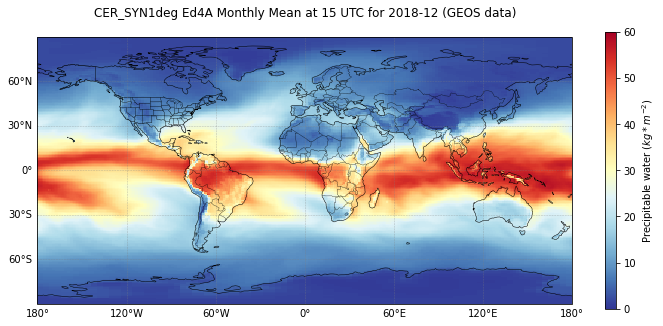

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_PW_2018_12_mean.png


In [37]:
CER_data_all_time = np.mean(CER_data, axis=0)
print(CER_data_all_time.shape)
    
# Handle 2D or 1D coordinate arrays
if lon_coords.ndim == 2 and lat_coords.ndim == 2:
    X, Y = lon_coords, lat_coords
else:
    X, Y = np.meshgrid(lon_coords, lat_coords)
    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the data (sorted by latitude to avoid ValueError)
im = plt.pcolormesh(X, Y, CER_data_all_time,

    cmap='RdYlBu_r',
    vmin=water_var_dict[var]['vmin'],
    vmax=water_var_dict[var]['vmax']
#                     ,
#     cbar_kwargs={
#         'shrink': 0.5,  # Make colorbar 70% of the plot height
#         'aspect': 25,   # Control width (higher = thinner)
#         'pad': 0.05,    # Space between plot and colorbar
#         'label': 'ERA5 Incoming Surface Solar Radiation (W/m²)'
#     }
)
plt.colorbar(im, 
             shrink = 0.5,  # Make colorbar 70% of the plot height
             aspect = 25,   # Control width (higher = thinner)
             pad = 0.05,    # Space between plot and colorbar
             label = f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']})$")

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month} (GEOS data)", fontsize=12, pad=20)
()
plt.tight_layout()
out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_mean.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")




## Opening ERA5 {var} data

In [48]:
era5_file_arg = base_dir+f"era5/single_levels/{year}/{month}/{water_var_dict[var]['era5_longname']}_MHour.nc"
path = Path(era5_file_arg)

ds_era5 = xr.open_dataset(path, engine="netcdf4")
ds_era5 = apply_lon_lat_conventions(ds_era5)

print(ds_era5)

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 24, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2018-12-01 ... 2018-12-01T23...
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
    number      int64 8B ...
    expver      (valid_time) <U4 384B ...
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    tcwv        (valid_time, latitude, longitude) float32 100MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T18:06 GRIB to CDM+CF via cfgrib-0.9.1...


## Plotting ERA5 {var} data at {UTC_hour_plot}

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_PW_2018_12_15.png


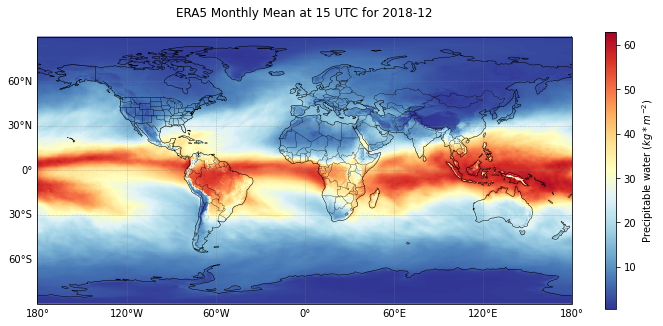

In [12]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_era5_sel_time = ds_era5.where(ds_era5['valid_time'].dt.hour == UTC_hour_plot, drop=True)

# Plot the data (sorted by latitude to avoid ValueError)
im = ds_era5_sel_time[water_var_dict[var]["era5_name"]].plot(
    ax=ax, 
    cmap='RdYlBu_r',
#     vmin=water_var_dict[var]['vmin'],
#     vmax=water_var_dict[var]['vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set title
ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')

print(f"Saved plot to: {out_png}")

## Plotting ERA5 {var} monthly mean data

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_PW_2018_12_24accum.png


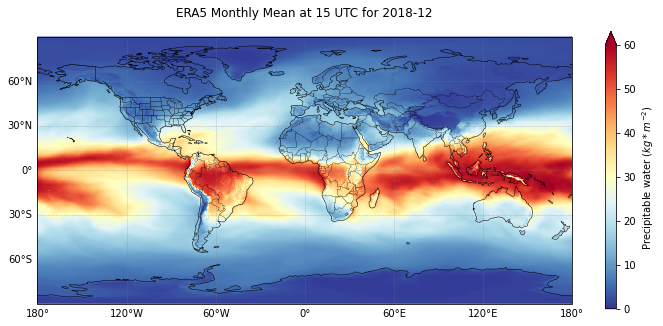

In [41]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_era5_all_time = ds_era5.mean(dim='valid_time')

# Plot the data (sorted by latitude to avoid ValueError)
im = ds_era5_all_time[water_var_dict[var]["era5_name"]].plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=water_var_dict[var]['vmin'],
    vmax=water_var_dict[var]['vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set title
ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_24accum.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')

print(f"Saved plot to: {out_png}")

## Opening MONAN data and extracting {var}

In [14]:
monan_dir="/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/derived_data/"

# monan_diag=f"MONAN_DIAG_G_MOD_GFS_2018111500_{year}{month}{day}{hour}.00.00.x655362L55.nc"
monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{water_var_dict[var]["monan_name"]}.nc'

monan_path = Path(monan_file)

ds_monan = xr.open_dataset(monan_path, engine="h5netcdf")
# # Adjusting sign of OLR / OLRC as negative outgoing
# if var=="OLR" or var=="OLRC":
#     ds_monan[water_var_dict[var]['monan_name']] = 0 - ds_monan[water_var_dict[var]['monan_name']]


monan_lons=ds_monan['lon']
monan_lats=ds_monan['lat']

print(ds_monan)

<xarray.Dataset> Size: 2GB
Dimensions:  (Time: 656, nCells: 655362)
Coordinates:
  * Time     (Time) datetime64[ns] 5kB 2018-12-01 ... 2018-12-28T07:00:00
    lat      (nCells) float64 5MB ...
    lon      (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Data variables:
    precipw  (Time, nCells) float32 2GB ...


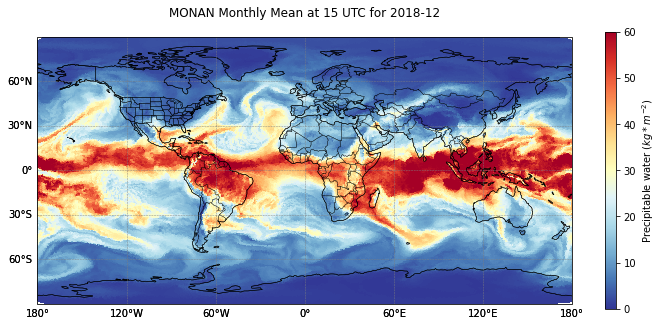

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_PW_2018_12_15.png


In [15]:
# Create triangulation
tri = Triangulation(monan_lons, monan_lats)

# monan_data_sel_time = ds_monan[water_var_dict[var]['monan_name']].where(ds_monan['hour'] == UTC_hour_plot, drop=True)[0]
monan_data_sel_time = ds_monan[water_var_dict[var]['monan_name']][0]


    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_data_sel_time, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=water_var_dict[var]['vmin'],
    vmax=water_var_dict[var]['vmax']
    )
plt.colorbar(tpc, label= f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

### Plotting monthly mean

In [39]:
monan_data_mean = ds_monan[water_var_dict[var]['monan_name']].mean(dim='Time')
print(monan_data_accum.values.min())
print(monan_data_accum.values.max())

0.4126072
63.587814


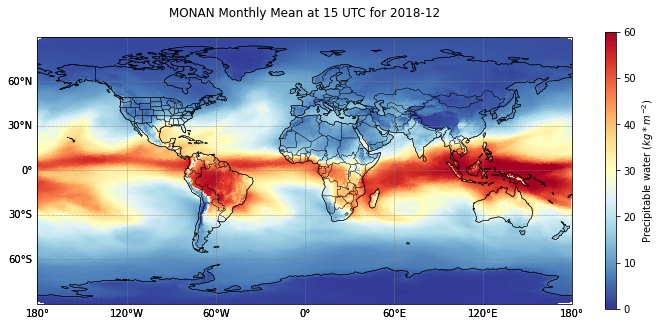

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_PW_2018_12_mean.png


In [35]:
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_data_mean, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=water_var_dict[var]['vmin'],
    vmax=water_var_dict[var]['vmax']
    )
plt.colorbar(tpc, label= f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_mean.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

In [88]:
era5_varname = water_var_dict[var]["era5_name"]
# Interpolate grid to irregular points
era5_at_points = ds_era5_all_time[era5_varname].interp(
    latitude=monan_lats,
    longitude=monan_lons)
monan_era5 = monan_data_mean - era5_at_points
print(monan_era5.shape)


(655362,)


In [90]:
CER_data_xa_mean = CER_data_xa.mean(dim='gmt_hr_index')
ceres_at_points = CER_data_xa_mean.interp(
    lat=monan_lats,
    lon=monan_lons)
# print(ceres_at_points)

monan_ceres = monan_data_mean - ceres_at_points
print(monan_ceres.shape)

(655362,)


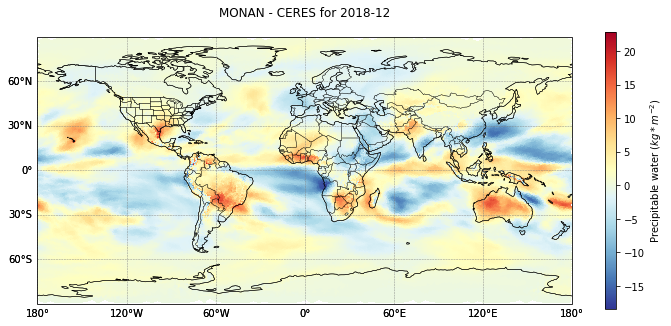

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN-CERES_PW_2018_12.png


In [92]:
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_ceres, 
    cmap="RdYlBu_r", 
    shading="flat",
#     vmin=water_var_dict[var]['vmin_diff'],
#     vmax=water_var_dict[var]['vmax_diff']
    )
plt.colorbar(tpc, label= f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN - CERES for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN-CERES_{var}_{year}_{month}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

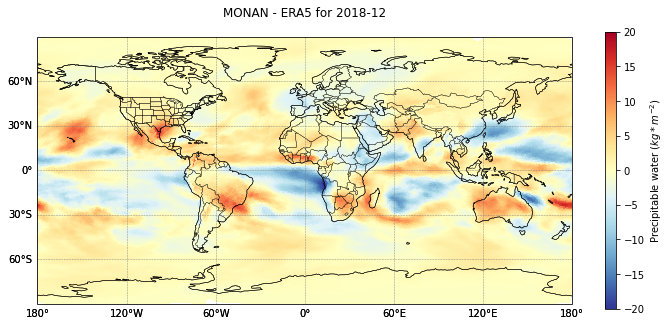

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN-ERA5_PW_2018_12.png


In [65]:
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_era5, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=water_var_dict[var]['vmin_diff'],
    vmax=water_var_dict[var]['vmax_diff']
    )
plt.colorbar(tpc, label= f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN - ERA5 for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN-ERA5_{var}_{year}_{month}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

## Plotting profile at {UTC_hour_plot} and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [23]:
#Extract data from ERA5
# Get the data variable at hour {UTC_hour_plot}
era5_data_2d = ds_era5_sel_time[water_var_dict[var]["era5_name"]][0]

# Find longitude index closest to target_lon
era5_lon = era5_data_2d['longitude'].values
era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
actual_lon = era5_lon[era5_lon_idx]

# Extract slice at that longitude
era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
era5_lat = era5_slice['latitude'].values
era5_values = era5_slice.values

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [21]:
# Get the data variable at hour {UTC_hour_plot}
ceres_data_2d = CER_data_sel_time

# Find longitude index closest to target_lon
ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
actual_ceres_lon = lon_coords[ceres_lon_idx]        

# Extract slice at that longitude
ceres_slice = ceres_data_2d[:,ceres_lon_idx]
ceres_values = ceres_slice

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [22]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d =monan_data_sel_time

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice = monan_lats[mask]
monan_slice = monan_data_2d[mask]

# Order by latitude
order = np.argsort(monan_lat_slice)
monan_lat_slice_sorted = monan_lat_slice[order]
monan_slice_sorted = monan_slice[order]


### Create the plot

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//PW_201812_15UTC_lon-60.png


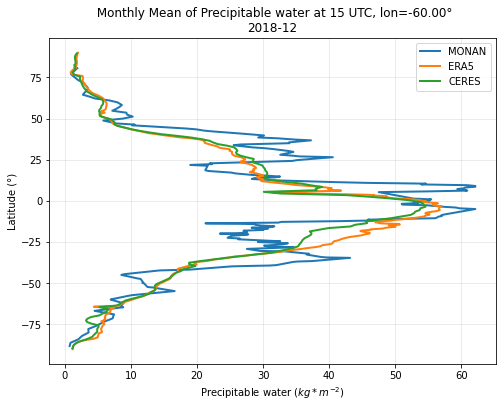

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(monan_slice_sorted ,monan_lat_slice_sorted, label=f"MONAN", linewidth=2)
plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
plt.plot(ceres_values, lat_coords, label=f"CERES", linewidth=2)
plt.xlabel(f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {water_var_dict[var]['label']} at {UTC_hour_plot} UTC, lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_{UTC_hour_plot}UTC_lon{int(actual_lon)}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

## Plotting profile for 24h mean and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [26]:
#Extract data from ERA5
# Get the data variable at hour {UTC_hour_plot}
era5_data_2d = ds_era5_all_time[water_var_dict[var]["era5_name"]]

# Find longitude index closest to target_lon
era5_lon = era5_data_2d['longitude'].values
era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
actual_lon = era5_lon[era5_lon_idx]

# Extract slice at that longitude
era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
era5_lat = era5_slice['latitude'].values
era5_values = era5_slice.values

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [31]:
# Get the data variable at hour {UTC_hour_plot}
ceres_data_2d = CER_data_all_time/24

# Find longitude index closest to target_lon
ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
actual_ceres_lon = lon_coords[ceres_lon_idx]        

# Extract slice at that longitude
ceres_slice = ceres_data_2d[:,ceres_lon_idx]
ceres_values = ceres_slice

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [28]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d =monan_data_accum

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice = monan_lats[mask]
monan_slice = monan_data_2d[mask]

# Order by latitude
order = np.argsort(monan_lat_slice)
monan_lat_slice_sorted = monan_lat_slice[order]
monan_slice_sorted = monan_slice[order]


### Create the plot

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//PW_201812_mean_lon-60.png


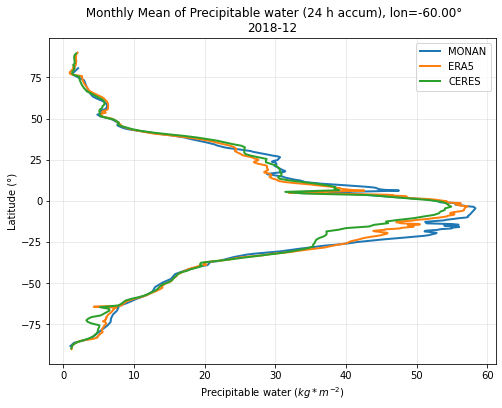

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(monan_slice_sorted ,monan_lat_slice_sorted, label=f"MONAN", linewidth=2)
plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
plt.plot(ceres_values, lat_coords, label=f"CERES", linewidth=2)
plt.xlabel(f"{water_var_dict[var]['label']} (${water_var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {water_var_dict[var]['label']} (24 h accum), lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_mean_lon{int(actual_lon)}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

### Closing MONAN and ERA5 files

In [33]:
ds_monan.close()
ds_era5.close()

### Closing CERES file

In [ ]:
try:
    sd.end()
except Exception:
    pass